# Linear Regression

This Notebook aims to build a Linear Regression Model (LRM) in order to have a comparison model vs. a shallow Neural Network (NN).

The comparison variable shall be the Mean Average Percentage Error (MAPE).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, pickle, warnings
import scipy.sparse
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from datetime import datetime

In [2]:
na = '<NA>'

df = pd.read_csv(r'../data_file/selected_data.csv')
df = df.replace(na, np.nan).drop(columns = [df.columns[0]])

obj_type, rooms, surface, zip_code_2_digits, zip_code_3_digits, canton, year_built, year_renovated, distance_to_station, lon, lat, price_square_metres, price = df.columns

## Helper Functions

- frame_to_numeric aims to force each string-formated value to numeric

In [3]:
def frame_to_numeric(frame):
    """transforms every value of a data frame to numeric if possible"""
    for column in frame.columns:
        try:
            frame.loc[:, column] = pd.to_numeric(frame.loc[:, column])
        except:
            continue #nothing toDo here
    return frame

df = frame_to_numeric(df)

- add_nearest_rooms_by_surface & add_surface_mean_by_nearest_rooms aims to fill missing surface and rooms values in order to have a larger dataset to train the LRM

In [4]:
def rooms_surface_mean(df):
    df = frame_to_numeric(df.loc[:, [rooms, surface]].dropna())
    return df.groupby(rooms).mean()

def add_rooms(row, df_rooms_mean):
    return df_rooms_mean.loc[row[rooms]]

def add_nearest_rooms_by_surface(df):
    """completes the dataframe rooms by the nearest neighbour based on the surface mean distance
    and the surface of the missing rooms objects"""
    df = df.reset_index(drop = True)
    df_rooms_mean = rooms_surface_mean(df)
    df_rooms_missing = df[df.loc[:, rooms].isna()].loc[:, [surface]]
    dist = cdist(df_rooms_missing, df_rooms_mean) #computes the distance between each pair of surface
    idx = np.argsort(dist) #gets sorted index (most left = lowest distance index)
    rooms_class = idx[:,0] #gets the room class (index)
    df_rooms_missing.loc[:, rooms] = rooms_class
    df_rooms_mean = df_rooms_mean.reset_index()
    df_rooms_missing.loc[:, rooms] = df_rooms_missing.apply(lambda row: add_rooms(row, df_rooms_mean), axis = 1)
    df.loc[df_rooms_missing.index, rooms] = df_rooms_missing.loc[:, rooms] #appends the missing rooms to the real data-frame
    return df

In [5]:
def add_surface(row, df_rooms_mean):
    return df_rooms_mean.loc[row[surface]]

def add_surface_mean_by_nearest_rooms(df):
    """completes the dataframe surface by the nearest neighbour surface mean based on the room distance
    of the missing surface objects"""
    df = df.reset_index(drop = True)
    df_rooms_mean = rooms_surface_mean(df).reset_index()
    df_surface_missing = df[df.loc[:, surface].isna()].loc[:, [rooms]]
    dist = cdist(df_surface_missing, df_rooms_mean.loc[:, [rooms]]) #computes the distance between each pair of rooms
    idx = np.argsort(dist) #gets sorted index (most left = lowest distance index)
    surface_class = idx[:,0] #gets the surface class (index)
    df_surface_missing.loc[:, surface] = surface_class
    df_surface_missing.loc[:, surface] = df_surface_missing.apply(lambda row: add_surface(row, df_rooms_mean), axis = 1)
    df.loc[df_surface_missing.index, surface] = df_surface_missing.loc[:, surface]
    return df

- handle_missing_numeric_feature completes missing values of a dataframe with an additional feature which has a value 1 if the value was not missing and 0 if it was

In [6]:
def handle_missing_numeric_feature(df, feature, na):
    """this function completes the missing vlaues of a data-frame with the median of the given numeric feature
    it adds a new column `feature`+'_'+`na` at the end of the feature index,
    which is going to be '1' if the value of the data object is missing and '0' otherwise 
    """
    df_copy = df.copy()
    na_index = pd.Index(df_copy.columns).get_loc(feature) + 1
    column = df_copy.loc[:, feature]
    column = column.replace(np.nan, na, regex = True)
    artificial_column = [1 if x == na else 0 for x in column] #comprehensions
    df.insert(na_index, feature+'_'+na, artificial_column)
    
    na_indexes = column[column == na].index
    feature_median = df_copy.loc[:, feature].median()
    df.loc[na_indexes, feature] = feature_median
    return df

def missing_numerical_features_controller(df, features, na):
    """this function just calls the :func:`handle_missing_numeric_feature` for each given feature"""
    for feature in features:
        df = handle_missing_numeric_feature(df, feature, na)
    return df

- one_hot_encoding transformes catecorical features to numeric with the one hot encoding method because the LRM just works with numerical features

In [7]:
def one_hot_encoding(df, na, feature_name, new_encoding = False):
    """performs a complete one-hit encoding on the specified feature of the dataframe
    adds a the prefix '_' to each unique encoding class
    set `new_encoding` = True if the data are not in the same order as before!!! otherwise it returns a false encoding
    separates automatically all missing values as it's own category named: feature_name+'_'+na
    returns: 
    -encoded data-frame
    -categories of the variable as an array
    """
    enc = OneHotEncoder()
    df = df.copy()
    delimiter = feature_name + '_'
    na_delimiter = '_' + na
    enc_dir = './enc'
    cat_dir = './cat'
    enc_path = enc_dir+'/'+feature_name+'.npz'
    cat_path = cat_dir+'/categories.pkl'
    encoding = False
    sparse_matrix = None
    category = None
    all_cat = {}
    
    #creates directories if not exists
    if not os.path.exists(enc_dir):
        encoding = True
        os.makedirs(enc_dir)
    if not os.path.exists(cat_dir):
        encoding = True
        os.makedirs(cat_dir)
        
    #gets the dictionary with all categories
    try:
        all_cat = load_obj(cat_path)
    except:
        pass
    
    #deletes files if they exists and new_encoding is True
    if new_encoding:
        encoding = True
        try:
            os.remove(enc_path)
        except:
            pass
        try:
            del all_cat[feature_name]
        except:
            pass
    
    #tries to get sparse matrix & head if new_encoding == False
    if not encoding:
        try:
            sparse_matrix = scipy.sparse.load_npz(enc_path)
            #check if size of sparse_matrix matches size of the df
            if sparse_matrix.shape[0] != df.shape[0]:
                sparse_matrix = None
            category = all_cat.get(feature_name)
        except:
            pass
    
    #perform actual encoding if necessary
    if (sparse_matrix is None) or (category is None):
        if df.loc[:, [feature_name]].isnull().values.any():
            df.loc[:, feature_name] = df.loc[:, feature_name].replace(np.nan, feature_name + na_delimiter, regex = True)
        selected_frame = delimiter + df.loc[:, feature_name].astype(str).to_frame()
        sparse_matrix = enc.fit_transform(selected_frame)
        category = enc.categories_[0]
        all_cat[feature_name] = category
        scipy.sparse.save_npz(enc_path, sparse_matrix)
        save_obj(all_cat, cat_path)
    
    #add encoded matrix to the df
    encoded_array = sparse_matrix.toarray()
    df_enc = pd.DataFrame(data = encoded_array, columns = category)
    category_sorted = np.sort(category)
    df_enc = df_enc[category_sorted]
    df = df.drop(columns = [feature_name])
    df[category_sorted] = df_enc
    return df, category_sorted

def save_obj(obj, path):
    if len(path) < 5:
        path = path + '.pkl'
    elif path[-4:] != '.pkl':
        path = path + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path):
    if len(path) < 5:
        path = path + '.pkl'
    elif path[-4:] != '.pkl':
        path = path + '.pkl'
    with open(path, 'rb') as f:
        return pickle.load(f)

def get_prepared_df(df, na, target_variable = None, categorical_features = [], numerical_features = [], new_encoding = False):
    """returns the data frame with the specified encoded features and the corresponding generated categories
    set `new_encoding` = True if the data are not in the same order as before!!! otherwise it returns a false encoding"""
    df_selected = df.loc[:, (numerical_features + categorical_features)]
    categories = {}
    for feature in categorical_features:
        df_selected, categories[feature] = one_hot_encoding(df_selected, na, feature, new_encoding)
    if target_variable is not None:
        df_selected[target_variable] = df.loc[:, target_variable]
    return df_selected, categories

def normalize_df(df, features):
    """normalizes the given numerical sample to mean 0 and std 1"""
    df[features] = (df.loc[:, features] - df.loc[:, features].mean(axis = 0) / df.loc[:, features].std(axis = 0))
    return df

def mape(y_true, y_pred): 
    """calculates the mean absolute percentage error (MAPE) of a continuous predicted variable"""
    return (np.mean(np.abs((y_true - y_pred) / y_true)) * 100).values[0]

## Linear Regression

In [8]:
def launch_regression(X_train, y_train, X_test, y_test, plot_result = False, math_op = None):
    lr = LinearRegression()
    if math_op == 'log10':
        y_train = np.log10(y_train)
    elif math_op == 'sqrt':
        y_train = np.sqrt(y_train)
        
    lr.fit(X_train, y_train)
    score = lr.score(X_train, y_train)
    
    predicted = lr.predict(X_test)
    if math_op == 'log10':
        predicted = 10**predicted
    elif math_op == 'sqrt':
        predicted = predicted**2
        
    mape_lr = mape(y_test, predicted)
    residuals = y_test - predicted
    intercept = lr.intercept_
    
    if plot_result:
        print('r^2 train: ', score)
        print('MAPE:', mape_lr[price], '%')
        fig, ax = plt.subplots(figsize=(15,8))
        _ = ax.plot(predicted, residuals, 'o', markeredgecolor='black', color='blue', alpha=0.1)
        _ = ax.grid(True)
        _ = ax.set_title('Tukey-Ascombe Plot')
        _ = ax.set_ylabel('$r$')
        _ = ax.set_xlabel('$\hat y$')
        
    return mape_lr, score
 

In [9]:
def val_lr_perf(df, cat_f, compl_num_f, miss_num_f, targ_var, na, bottom_up = True, new_enc = False, plot_result = False):
    """greedy bottom up (default) or top down model performance validation"""
    num_f = compl_num_f + miss_num_f
    remaining_f = compl_num_f + miss_num_f + cat_f
    ranking = [] #[feature_name, mape, r2]
    df_targ_var = df.loc[:, targ_var]
    first_loop = True
    
    #error vars
    mape_error = 999999
    r2_error = 0
    mape_error_best = mape_error
    r2_error_best = r2_error
    
    #enc vars
    enc_features = []
    enc_loop = None
    
    if bottom_up:
        df_current = pd.DataFrame(columns = [])
        cat = {}
    else:
        df_current, cat = get_prepared_df(df, na, None, cat_f, num_f, new_encoding = new_enc)
        df_current = missing_numerical_features_controller(df_current, miss_num_f, na)
    
    while ((len(remaining_f) > 0 and bottom_up) or (len(remaining_f) > 1 and (not bottom_up))):
        df_current_best = df_current.copy()
        best_feature = None
        current_error_package = {}
        df_package = {}
        for feature in remaining_f:
            df_current_trial = df_current.copy()  
            if bottom_up:
                df_current_trial[feature] = df.loc[:, feature]
                if feature in cat_f:
                    if (feature not in enc_features) and (new_enc):
                        enc_features.append(feature)
                        enc_loop = True
                    elif (new_enc):
                        enc_loop = False
                    df_current_trial, cat_trial = one_hot_encoding(df_current_trial, na, feature, new_encoding = enc_loop)
                elif feature in miss_num_f:
                    df_current_trial = handle_missing_numeric_feature(df_current_trial, feature, na)
                elif feature in compl_num_f:
                    pass #nothing toDo here
            elif not first_loop:
                #top_down
                if feature in cat_f:
                    df_current_trial = df_current_trial.drop(columns = cat[feature])
                elif feature in miss_num_f:
                    df_current_trial = df_current_trial.drop(columns = [feature, feature+'_'+na])
                elif feature in compl_num_f:
                    df_current_trial = df_current_trial.drop(columns = [feature])
                    
            X_train, X_test, y_train, y_test = train_test_split(df_current_trial, df_targ_var, test_size = 0.25, random_state = 42)
            mape_lr, score = launch_regression(X_train, y_train, X_test, y_test, plot_result = False, math_op = None)
            current_error_package[feature] = [mape_lr, score]
            df_package[feature] = df_current_trial
            
            #check if the feature increased performance
            if mape_lr < mape_error_best:
                mape_error_best = mape_lr
                r2_error_best = score #should get better too while mape gets better
                best_feature = feature
                df_current_best = df_current_trial
                
            #adjust vars for first loop top_down
            if  (not bottom_up) and first_loop:
                first_loop = False
                mape_error_best = mape_lr
                r2_error_best = score
                best_feature = 'all_features'
                break
                
        #if performance has not imporved (important for top_down)
        if best_feature is None:
            mape_errors_only = {}
            for feature in current_error_package.keys(): #could be implemented more efficiently???
                mape_errors_only[feature] = current_error_package.get(feature)[0]
            best_feature = min(mape_errors_only, key = mape_errors_only.get)
            mape_error_best = current_error_package.get(best_feature)[0]
            r2_error_best = current_error_package.get(best_feature)[1]
            df_current_best = df_package.get(best_feature)
        
        #update loop
        ranking.append([best_feature, mape_error_best, r2_error_best])
        df_current = df_current_best
        mape_error = mape_error_best
        r2_error = r2_error_best
        if best_feature in remaining_f: #prevents trying to remove `best_feature` = 'all_features'
            remaining_f.remove(best_feature)
            
    ranking = pd.DataFrame(ranking, columns = ['feature', 'mape', 'r2'])
    if plot_result:
        if bottom_up:
            title = 'bottom_up performance'
        else:
            title = 'top_down performance'
        suffix = ' '+ str(df_current.shape[0]) +' rental objects'
        name_values = ranking.loc[:, 'feature']
        mape_values = ranking.loc[:, 'mape']
        r2_values = ranking.loc[:, 'r2']
        #MAPE figure
        plt.figure(figsize = (15,6))
        plt.title(title + ' MAPE' + suffix)
        plt.ylabel('MAPE')
        plt.plot(name_values, mape_values)
        plt.show()
        #R2 figure
        plt.figure(figsize = (15,6))
        plt.title(title + 'R$^2$' + suffix)
        plt.ylabel('R$^2$')
        plt.plot(name_values, r2_values)
        plt.show()
        
    return ranking
            

In [10]:
def select_approp_df(df, na, selected_features, missing_values_included = False, reset_idx = True):
    df = df.copy()
    if missing_values_included:
        df = add_nearest_rooms_by_surface(df)
        df = add_surface_mean_by_nearest_rooms(df)
    else:
        df = df.loc[:, selected_features]
        if year_renovated in df.columns:
            year_renovated_frame = df.loc[:, [year_renovated]]
            df = df.drop(columns = [year_renovated])
            df = df.dropna()
            df[year_renovated] = year_renovated_frame.iloc[df.index, :]
        else:
            df = df.dropna()
        if reset_idx:
            df = df.reset_index(drop = True)
    return df

### Linear Regression with complete Data Objects

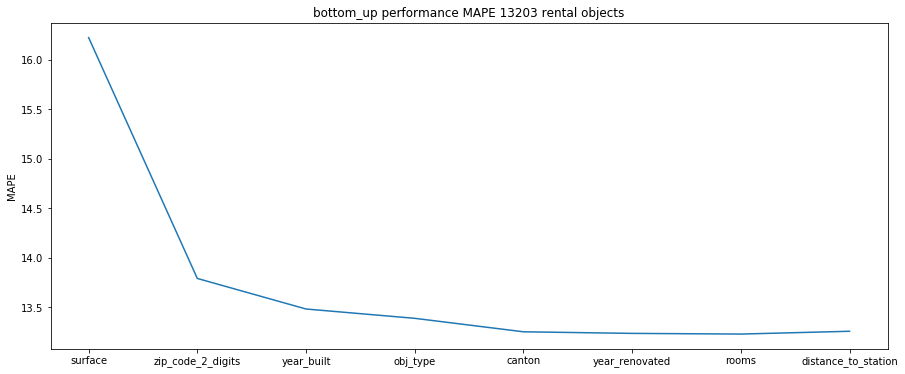

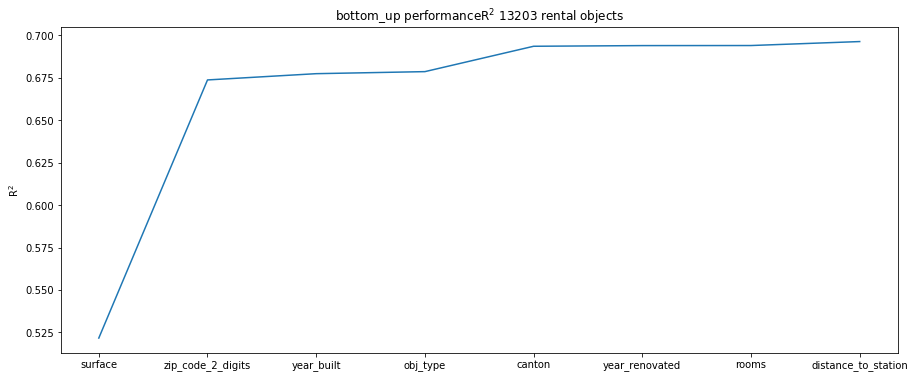

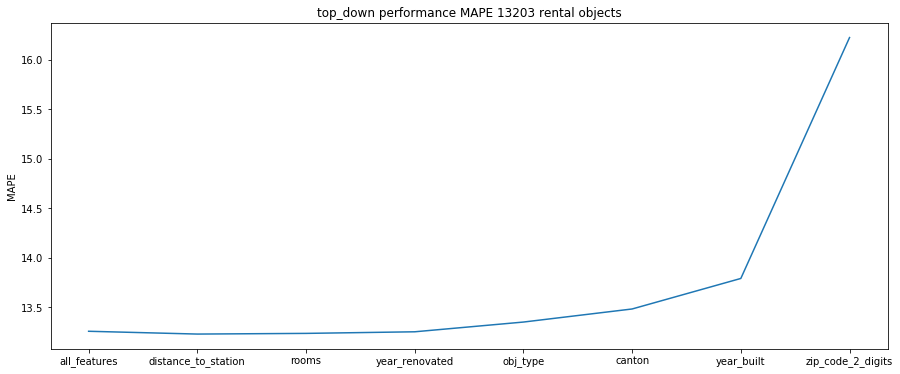

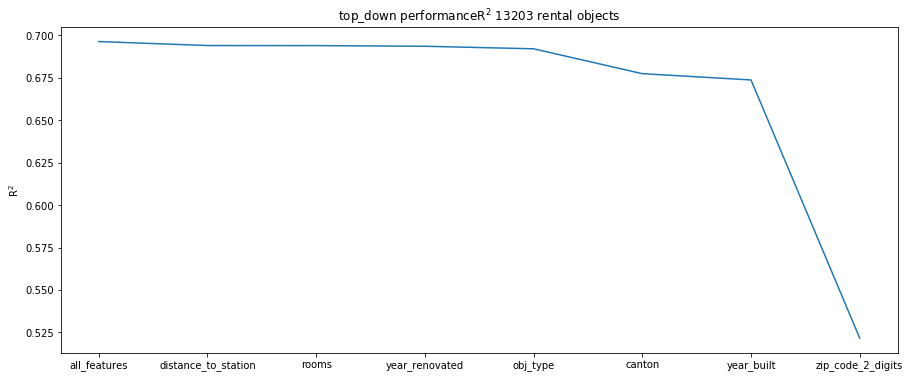

In [11]:
def init(df, na, missing_values_included = False):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    cat_f = [obj_type, canton, zip_code_2_digits]
    compl_num_f = [surface, rooms, distance_to_station]
    miss_num_f = [year_renovated, year_built]
    targ_var = [price]
    selected_features = cat_f + compl_num_f + miss_num_f + targ_var
    
    df = select_approp_df(df, na, selected_features, missing_values_included)

    result_bottom_up =  val_lr_perf(df, cat_f, compl_num_f, miss_num_f, targ_var, na, 
                             bottom_up = True, new_enc = True, plot_result = True)
    result_top_down = val_lr_perf(df, cat_f, compl_num_f, miss_num_f, targ_var, na, 
                             bottom_up = False, new_enc = True, plot_result = True)
    
    return result_bottom_up, result_top_down
 
result_bottom_up, result_top_down = init(df, na, False)

In [12]:
bottom_up_top_score_index = result_bottom_up.loc[:, 'mape'].idxmin(axis = 1)
bottom_top_down_score_index = result_top_down.loc[:, 'mape'].idxmin(axis = 1)

In [13]:
result_bottom_up.iloc[bottom_up_top_score_index, 1:]

mape     13.2313
r2      0.694077
Name: 6, dtype: object

In [14]:
result_bottom_up

,feature,mape,r2
0,surface,16.221399,0.521657
1,zip_code_2_digits,13.792151,0.673795
2,year_built,13.484028,0.677488
3,obj_type,13.390053,0.678692
4,canton,13.254276,0.693643
5,year_renovated,13.238133,0.694038
6,rooms,13.231294,0.694077
7,distance_to_station,13.259534,0.696417


In [15]:
result_top_down.iloc[bottom_top_down_score_index, 1:]

mape     13.2313
r2      0.694077
Name: 1, dtype: object

In [16]:
result_top_down

,feature,mape,r2
0,all_features,13.259534,0.696417
1,distance_to_station,13.231294,0.694077
2,rooms,13.238133,0.694038
3,year_renovated,13.254276,0.693643
4,obj_type,13.352463,0.692148
5,canton,13.484328,0.677488
6,year_built,13.792151,0.673795
7,zip_code_2_digits,16.221399,0.521657


#### Result 13203 Rental Objects

The min MAPE with 13203 rental objects is $\approx 13.23\%$. Surprisingly, the distance to the next train stop is not relevant for modelling. On the contrary, the performance of the LRM deteriorates. This is not the expected behaviour according to data analysis, where it is strongly evident that the variance of prices decreases sharply the further away the rental objects are from the train stops.

In addition, the number of rooms hardly plays a role. I suspect that this is related to the strong correlation between land area and number of rooms according to data analysis, and that land area is more relevant for price forecasting. Both methods, bottom-up and top-down show the same result.

### Linear Regression with incomplete Data Objects

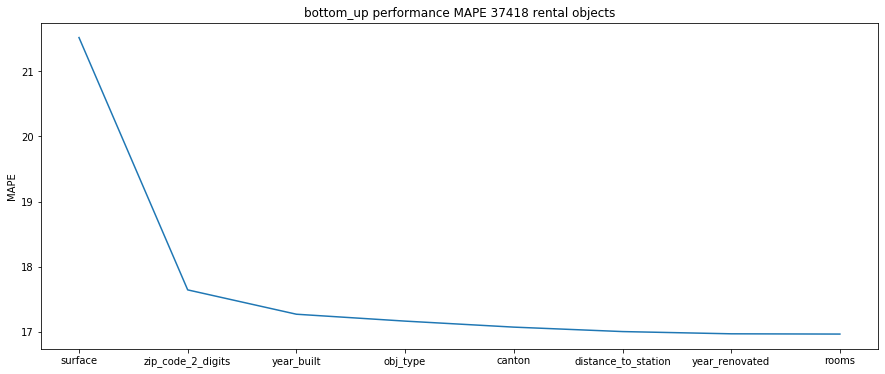

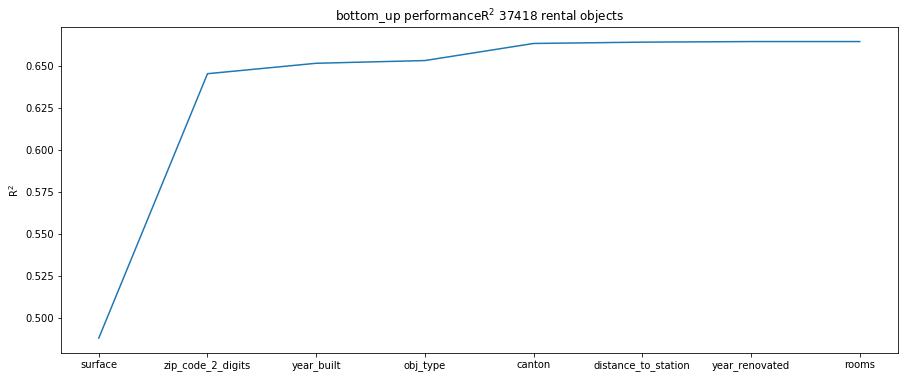

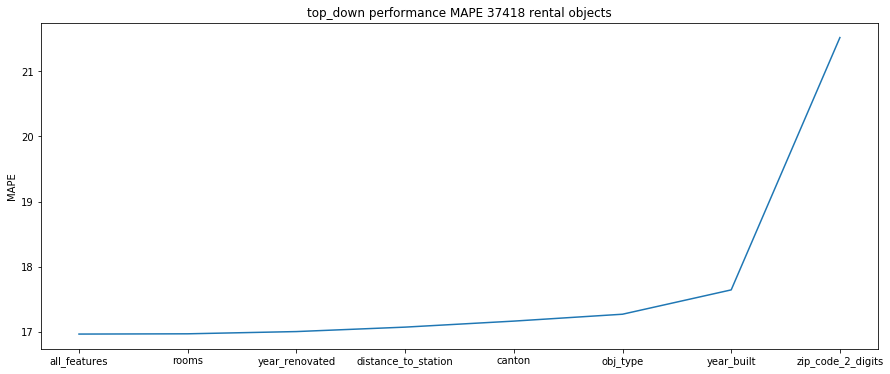

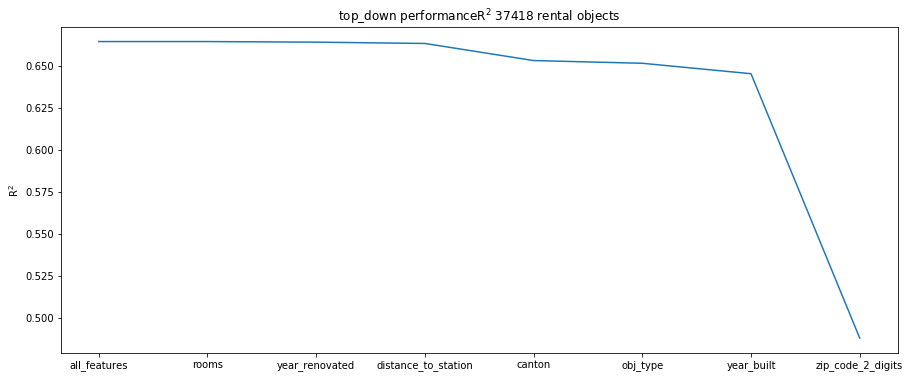

In [17]:
result_bottom_up, result_top_down = init(df, na, True)

#### Result 37418 Rental Objects

The analysis with all 37418 rental properties shows a deterioration in MAPE of $\approx 4\%$. This is despite the fact that there are massively more data objects. I suspect that the completion of the number of rooms and the rental space have a negative influence. Nevertheless, the significance of the individual features is the same with regard to the reduction of the error.

### Geographic Data Distribution

Here I am interested in the geographical distribution of the data objects used for the creation of the LRM to ensure the representativeness of the model. For this reason, this analysis is located here, because it was not clear beforehand whether all features were needed to create the model.

The plots show that the geographical distribution is supposed to be ok for all data points and for those that have missing and no missing values.

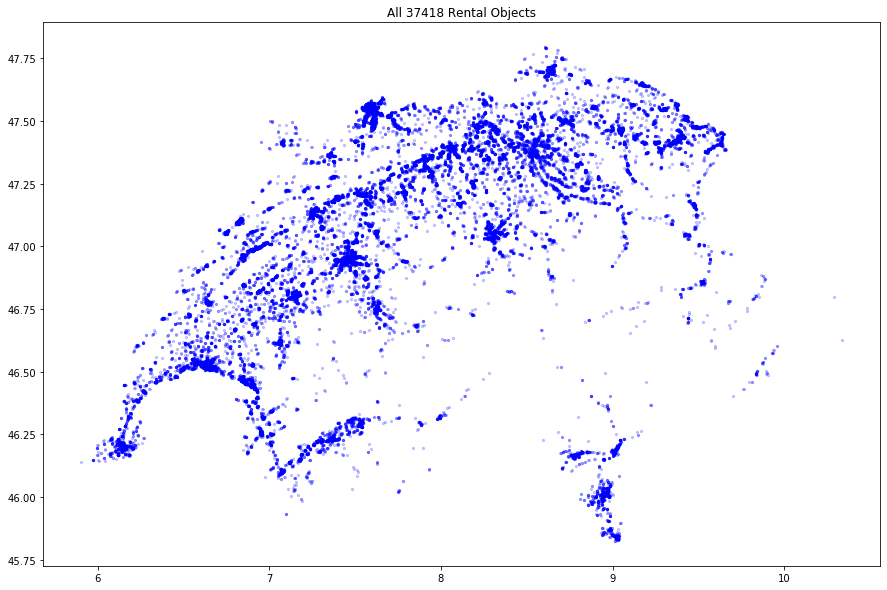

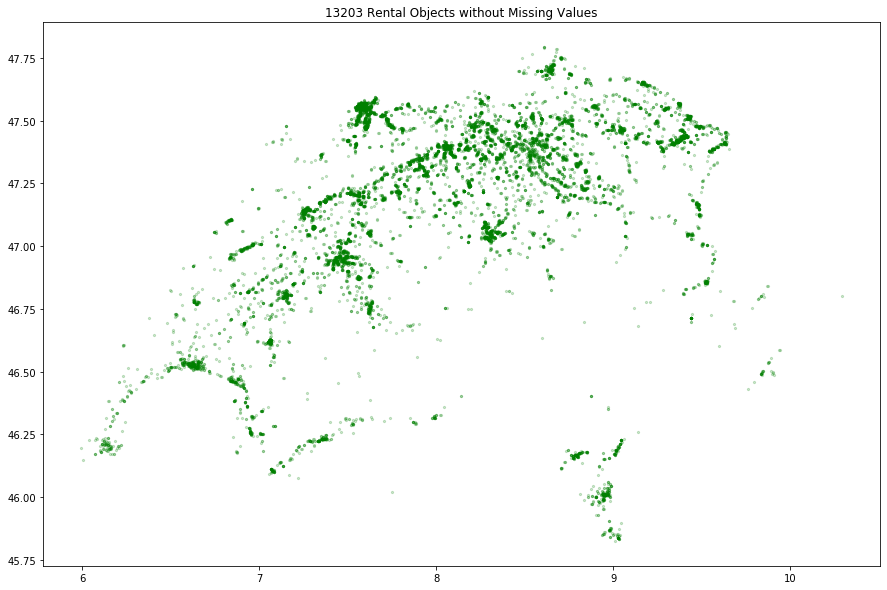

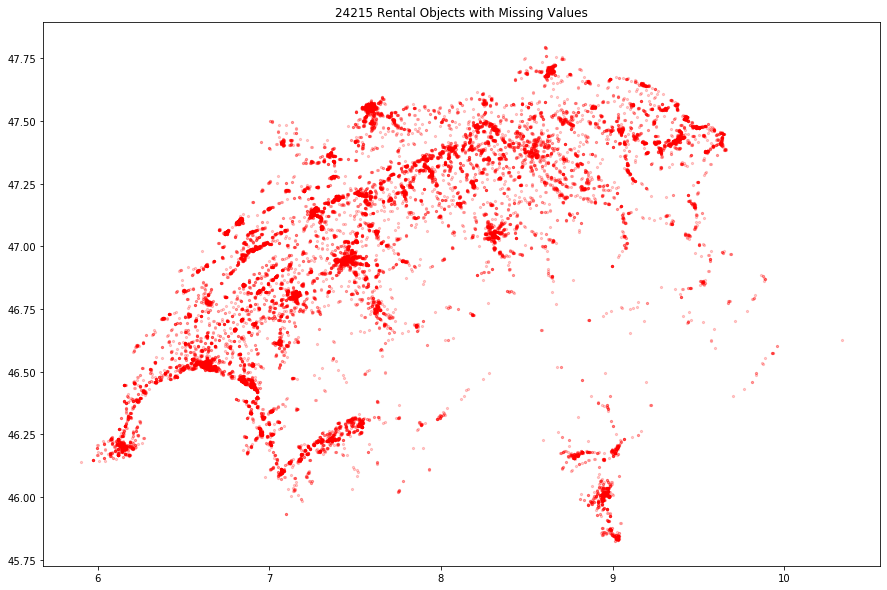

In [18]:
def plot_df_selection_distribution(df, na):
    cat_f = [obj_type, canton, zip_code_2_digits]
    compl_num_f = [surface, rooms, distance_to_station, lat, lon]
    miss_num_f = [year_renovated, year_built]
    targ_var = [price]
    selected_features = cat_f + compl_num_f + miss_num_f + targ_var
    
    df_missing_incl = select_approp_df(df, na, selected_features, missing_values_included = True, reset_idx = False)
    df_all_features = select_approp_df(df, na, selected_features, missing_values_included = False, reset_idx = False)
    drop_df = df_missing_incl.index.isin(df_all_features.index)
    df_not_all_features = df_missing_incl[~drop_df]
    
    plt.figure(figsize = (15,10))
    plt.scatter(df_missing_incl.loc[:, lon], df_missing_incl.loc[:, lat], color = 'b', s = 5, alpha = 0.2)
    plt.title('All '+str(df_missing_incl.shape[0])+' Rental Objects')
    plt.show()
    plt.figure(figsize = (15,10))
    plt.scatter(df_all_features.loc[:, lon], df_all_features.loc[:, lat], color = 'g', s = 5, alpha = 0.2)
    plt.title(str(df_all_features.shape[0])+' Rental Objects without Missing Values')
    plt.show()
    plt.figure(figsize = (15,10))
    plt.scatter(df_not_all_features.loc[:, lon], df_not_all_features.loc[:, lat], color = 'r', s = 5, alpha = 0.2)
    plt.title(str(df_not_all_features.shape[0])+' Rental Objects with Missing Values')
    plt.show()

plot_df_selection_distribution(df, na)